<a href="https://colab.research.google.com/github/arminnv/Deep-Learning-Fall-2024/blob/main/HW1/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Full Name : Armin Navardi
### Student Number : 99105129


# Support Vector Machines (SVM)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

## Goal
In this assignment, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

In [27]:
df = pd.read_csv("Liver_Disease.csv")

### Pre-Processing

#### Exploratory Data Analysis:
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

(583, 11)
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
label                         0
dtype: int64
414
165


<ipython-input-28-354cd20d8f80>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df[df['label'] == 1], ax=axs[1, 0], palette='Set2')
<ipython-input-28-354cd20d8f80>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df[df['label'] == 2], ax=axs[1, 1], palette='Set2')


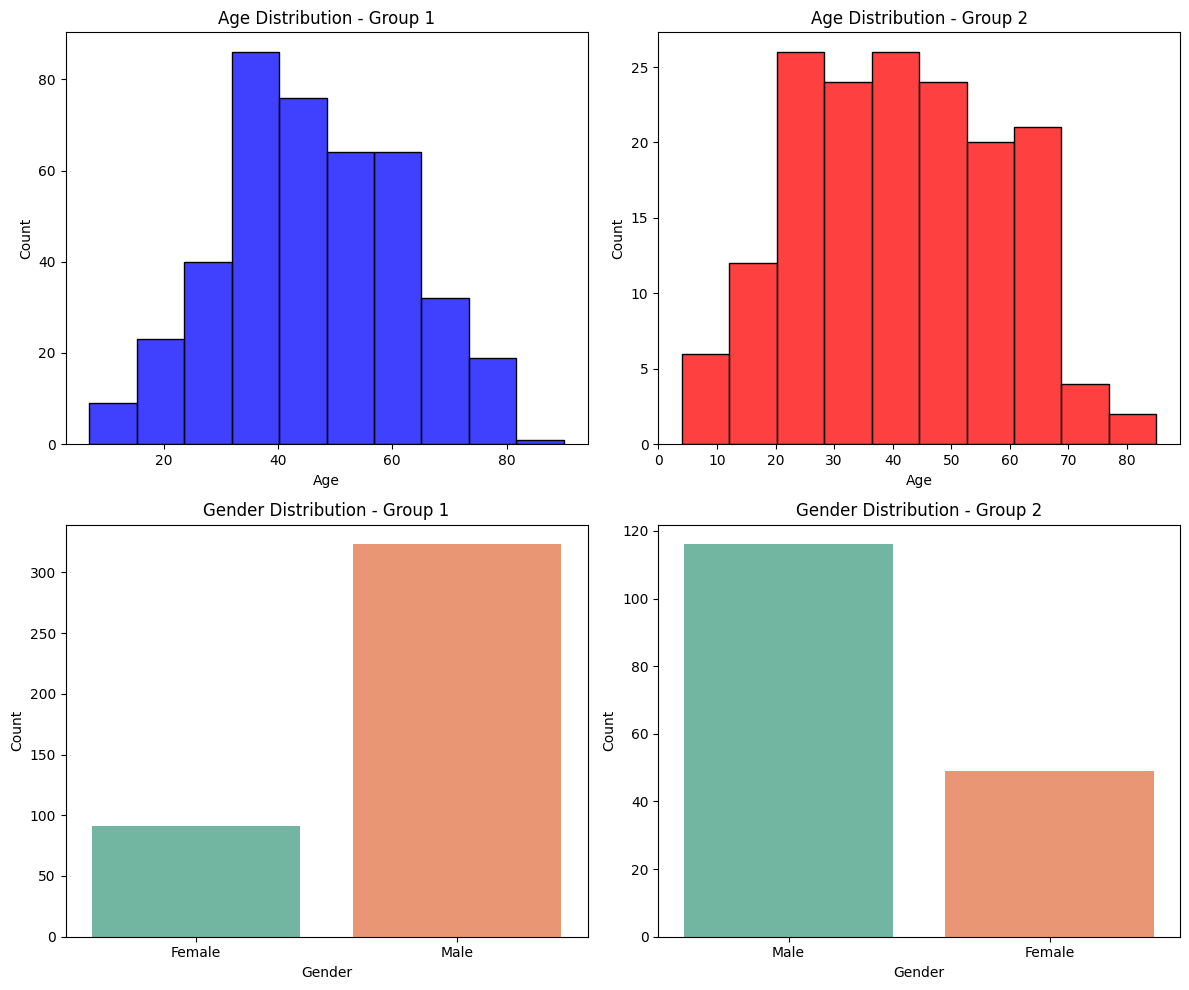

In [28]:
###############################################################################
## TODO: Find the shape of the dataset.                                      ##

print(df.shape)
###############################################################################

###############################################################################
## TODO: Check if there is missing entries in the dataset columnwise.        ##
print(df.isnull().sum())
df = df.dropna()
###############################################################################

###############################################################################
## TODO: Check whether the dataset is balanced or not.                       ##
print(sum(df['label']==1))
print(sum(df['label']==2))
###############################################################################

###############################################################################
## TODO: plot the age distirbution and gender distrbution for both group    ##
## of patients.(4 plots)                                                    ##
# Set up the figure and axes for 4 subplots (2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Age distribution for Group 1
sns.histplot(df[df['label'] == 1]['Age'], bins=10, kde=False, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Age Distribution - Group 1')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Count')

# Plot 2: Age distribution for Group 2
sns.histplot(df[df['label'] == 2]['Age'], bins=10, kde=False, ax=axs[0, 1], color='red')
axs[0, 1].set_title('Age Distribution - Group 2')
axs[0, 1].set_xlabel('Age')
axs[0, 1].set_ylabel('Count')

# Plot 3: Gender distribution for Group 1
sns.countplot(x='Gender', data=df[df['label'] == 1], ax=axs[1, 0], palette='Set2')
axs[1, 0].set_title('Gender Distribution - Group 1')
axs[1, 0].set_xlabel('Gender')
axs[1, 0].set_ylabel('Count')

# Plot 4: Gender distribution for Group 2
sns.countplot(x='Gender', data=df[df['label'] == 2], ax=axs[1, 1], palette='Set2')
axs[1, 1].set_title('Gender Distribution - Group 2')
axs[1, 1].set_xlabel('Gender')
axs[1, 1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()
###############################################################################


##### Question: What do you conclude from the plots?

#### Outlier Detection & Removal
Check whether we have outliers in the data. If there are, delete them.

In [35]:
################################################################################
## TODO
df_numerical = df.drop(['Gender'], axis=1)

Q1 = df_numerical.quantile(0.25)
Q3 = df_numerical.quantile(0.75)
IQR = Q3 - Q1

# Define outlier limits
lower_bound = Q1 - 5 * IQR
upper_bound = Q3 + 5 * IQR

# Remove outliers
df_no_outliers = df[~((df_numerical < lower_bound) | (df_numerical > upper_bound)).any(axis=1)]
labels = df_no_outliers['label']
print(df_no_outliers.shape)
################################################################################


(497, 11)


#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.
also feel free to do more feature engineering techniques if needed.

In [36]:
################################################################################
## TODO: Normalize numerical features to be between 0 and 1                   ##
## Note that just numerical fetures should be normalized.                     ##

numerical_features = df_no_outliers.select_dtypes(include=[np.number])

df_no_outliers[numerical_features.columns] = (numerical_features - numerical_features.min()) / (numerical_features.max() - numerical_features.min())
df_no_outliers['Gender'] = df_no_outliers['Gender'].replace({'Male': 0, 'Female': 1})
################################################################################

<ipython-input-36-d7cbbb4f70be>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers[numerical_features.columns] = (numerical_features - numerical_features.min()) / (numerical_features.max() - numerical_features.min())
<ipython-input-36-d7cbbb4f70be>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_no_outliers['Gender'] = df_no_outliers['Gender'].replace({'Male': 0, 'Female': 1})
<ipython-input-36-d7cbbb4f70be>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


### SVM

#### spliting data

In [37]:
## TODO Split the data into test and training sets.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_no_outliers.drop(['label'], axis=1), labels, test_size=0.2, random_state=42)

### SVM using Scikit-Learn:
First of all train an svm model with default parameters and report its.

In [38]:
#########################################################################################
## TODO

# Train SVM model with default parameters
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on test set and calculate accuracy
y_pred = svm_model.predict(X_test)
accuracy = np.mean(y_test == y_pred)

print(f"Default SVM Model Accuracy: {accuracy:.2f}")
#########################################################################################


Default SVM Model Accuracy: 0.77


#### Grid Search
Use Grid search and validation set to find the best parameters for your SVM model.

In [120]:
#########################################################################################
## TODO

from sklearn.model_selection import train_test_split, GridSearchCV

# Define parameter grid
param_grid = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale']
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

# Display best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Balanced Accuracy:", grid_search.best_score_)

#########################################################################################


Best Parameters: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Balanced Accuracy: 0.689634703964901


Train an svm model on the entire training data using the parameters you found in the previous step.

In [121]:
#########################################################################################
## TODO

best_params = grid_search.best_params_  # Use previously found best params
model = SVC(**best_params)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = np.mean(y_test == y_pred)
print("Model Accuracy:", accuracy)
#########################################################################################


Model Accuracy: 0.72


### Confusion Matrix
Plot the confusion matrix and report the model accuracy on test set.
What does each entry of the confusion matrix mean?

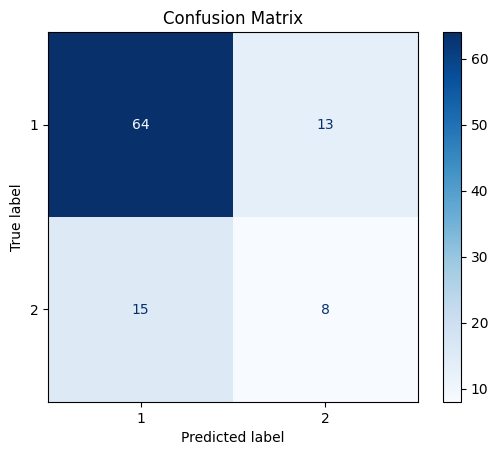

In [122]:
#########################################################################################
## TODO

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
# Plot the confusion matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
#########################################################################################


Add some outliers to the dataset, train an SVM and logistic regression model, and compare the results.

SVM Accuracy: 0.72
Logistic Regression Accuracy: 0.69


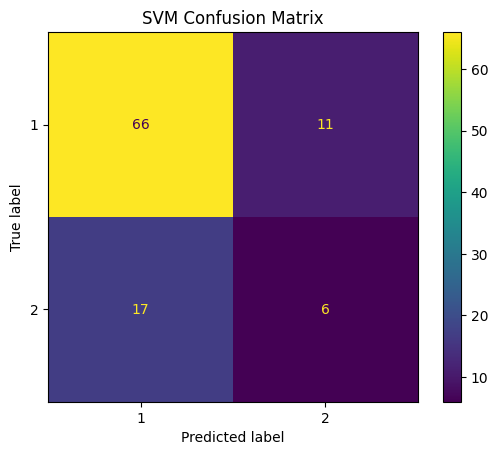

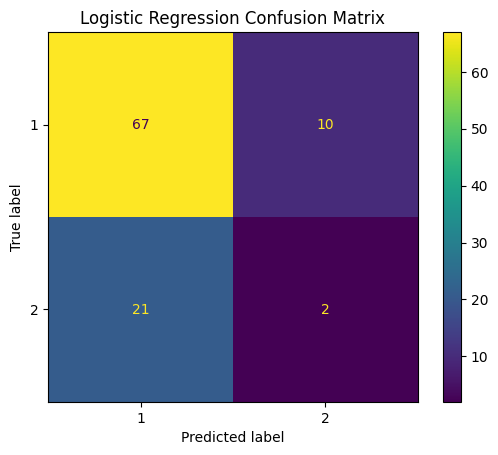

In [123]:
#########################################################################################
## TODO
import random
from sklearn.linear_model import LogisticRegression

X_corrupted =  df_no_outliers.drop(['label'], axis=1)
indexes = random.sample(range(1, len(X_corrupted)), 20)
X_corrupted.iloc[indexes] += 5
X_train, X_test, y_train, y_test = train_test_split(X_corrupted, labels, test_size=0.2, random_state=42)

#best_params = {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}
svm_model = SVC(**grid_search.best_params_).fit(X_train, y_train)
log_reg_model = LogisticRegression().fit(X_train, y_train)

svm_acc = accuracy_score(y_test, svm_model.predict(X_test))
log_reg_acc = accuracy_score(y_test, log_reg_model.predict(X_test))
print("SVM Accuracy:", svm_acc)
print("Logistic Regression Accuracy:", log_reg_acc)

ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test)
plt.title("SVM Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(log_reg_model, X_test, y_test)
plt.title("Logistic Regression Confusion Matrix")
plt.show()
#########################################################################################
